# Text Preprocessing and Baseline Model

This notebook implements text preprocessing pipeline and builds a baseline model using bag-of-words and logistic regression.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')


def safe_nltk_download(resource, subdir=None):
    """Download NLTK resources only if missing."""
    try:
        if subdir:
            nltk.data.find(f"{subdir}/{resource}")
        else:
            nltk.data.find(resource)
    except LookupError:
        nltk.download(resource)

# Punkt tokenizer (NEEDS BOTH!)
safe_nltk_download('punkt', 'tokenizers')
safe_nltk_download('punkt_tab', 'tokenizers')

# Stopwords
safe_nltk_download('stopwords', 'corpora')

# WordNet / Lemmatizer data
safe_nltk_download('wordnet', 'corpora')
safe_nltk_download('omw-1.4', 'corpora')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nishantdoss/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nishantdoss/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Load Data

In [71]:
# DATA PERSISTENCE: Load variables from previous notebook
import pickle
import os

print("📂 LOADING DATA FROM PREVIOUS NOTEBOOK...")

try:
    # Load from notebook 1 if available
    if os.path.exists('../data/persistence/notebook1_df.csv'):
        print("✅ Loading data from Notebook 1...")
        df = pd.read_csv('../data/persistence/notebook1_df.csv')
        
        with open('../data/persistence/notebook1_variables.pkl', 'rb') as f:
            notebook1_vars = pickle.load(f)
            
        print(f"📊 Loaded dataset with {len(df)} articles")
        print(f"📈 Dataset info: {notebook1_vars['fake_count']} fake, {notebook1_vars['true_count']} true")
        print("🔗 Continuing from Notebook 1 data...")
        
    else:
        print("⚠️ No previous notebook data found, loading from raw files...")
        df = pd.read_csv('../data/combined_news_dataset.csv')
        print(f"📊 Loaded raw dataset with {len(df)} articles")
        
except Exception as e:
    print(f"⚠️ Error loading previous data: {e}")
    print("📂 Loading from raw files as fallback...")
    df = pd.read_csv('../data/combined_news_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")

📂 LOADING DATA FROM PREVIOUS NOTEBOOK...
✅ Loading data from Notebook 1...
📊 Loaded dataset with 44898 articles
📈 Dataset info: 23481 fake, 21417 true
🔗 Continuing from Notebook 1 data...
Dataset shape: (44898, 8)
Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64


In [72]:
# Load the combined dataset
df = pd.read_csv('../data/combined_news_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")

Dataset shape: (44898, 8)
Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64


## Text Preprocessing Pipeline

In [73]:
class TextPreprocessor:
    def __init__(self, use_stemming=True, remove_stopwords=True):
        self.use_stemming = use_stemming
        self.remove_stopwords = remove_stopwords
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
    
    def clean_text(self, text):
        """Basic text cleaning"""
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    def tokenize_and_process(self, text):
        """Tokenize and apply stemming/lemmatization"""
        tokens = word_tokenize(text)
        
        # Remove stopwords
        if self.remove_stopwords:
            tokens = [token for token in tokens if token not in self.stop_words]
        
        # Apply stemming or lemmatization
        if self.use_stemming:
            tokens = [self.stemmer.stem(token) for token in tokens]
        else:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    
    def preprocess(self, text):
        """Full preprocessing pipeline"""
        if pd.isna(text):
            return ''
        
        # Clean text
        text = self.clean_text(text)
        
        # Tokenize and process
        text = self.tokenize_and_process(text)
        
        return text

In [74]:
# Initialize preprocessor
preprocessor = TextPreprocessor(use_stemming=True, remove_stopwords=True)

# Test preprocessing on a sample
sample_text = df.iloc[0]['text'][:500]  # First 500 chars
print("Original text:")
print(sample_text)
print("\n" + "="*50 + "\n")
print("Preprocessed text:")
print(preprocessor.preprocess(sample_text))

Original text:
21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements on Judge Jeanine Pirro s show recently. While discussing the halt that was imposed on President Trump s Executive Order on travel. Stein referred to the judgement by the 9th Circuit Court in Washington state as a  Coup d tat against the executive branch and against the constitution.  Stein


Preprocessed text:
st centuri wire say ben stein reput professor pepperdin univers also hollywood fame appear tv show film ferri bueller day made provoc statement judg jeanin pirro show recent discuss halt impos presid trump execut order travel stein refer judgement th circuit court washington state coup tat execut branch constitut stein


In [75]:
# Combine title and text for richer features
df['combined_text'] = df['title'] + ' ' + df['text']

# Apply preprocessing (this may take a while for the full dataset)
print("Preprocessing text... (this may take several minutes)")
df['processed_text'] = df['combined_text'].apply(preprocessor.preprocess)

# Remove empty texts
df = df[df['processed_text'] != ''].reset_index(drop=True)

print(f"Dataset shape after preprocessing: {df.shape}")
print("\nSample processed texts:")
for i in range(3):
    print(f"\n{i+1}. Label: {df.iloc[i]['label']}")
    print(df.iloc[i]['processed_text'][:200] + '...')

Preprocessing text... (this may take several minutes)
Dataset shape after preprocessing: (44889, 10)

Sample processed texts:

1. Label: 0
ben stein call th circuit court commit coup dtat constitut st centuri wire say ben stein reput professor pepperdin univers also hollywood fame appear tv show film ferri bueller day made provoc stateme...

2. Label: 1
trump drop steve bannon nation secur council washington reuter us presid donald trump remov chief strategist steve bannon nation secur council wednesday revers controversi decis earli year give polit ...

3. Label: 1
puerto rico expect us lift jone act ship restrict reuter puerto rico governor ricardo rossello said wednesday expect feder govern waiv jone act would lift restrict ship provid aid island devast hurric...


## Train-Test Split

In [76]:
# Split the data
X = df['processed_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set label distribution:")
print(y_train.value_counts())
print(f"\nTest set label distribution:")
print(y_test.value_counts())

Training set size: 35911
Test set size: 8978

Training set label distribution:
label
0    18777
1    17134
Name: count, dtype: int64

Test set label distribution:
label
0    4695
1    4283
Name: count, dtype: int64


## Baseline Models

### 1. Bag of Words + Logistic Regression

In [77]:
# Count Vectorizer + Logistic Regression
bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

print("Training Bag of Words + Logistic Regression...")
bow_pipeline.fit(X_train, y_train)

# Predictions
bow_pred = bow_pipeline.predict(X_test)
bow_accuracy = accuracy_score(y_test, bow_pred)

print(f"\nBag of Words + Logistic Regression Accuracy: {bow_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, bow_pred, target_names=['Fake', 'True']))

Training Bag of Words + Logistic Regression...

Bag of Words + Logistic Regression Accuracy: 0.9962

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4695
        True       1.00      1.00      1.00      4283

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



### 2. TF-IDF + Logistic Regression

In [78]:
# TF-IDF + Logistic Regression
tfidf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

print("Training TF-IDF + Logistic Regression...")
tfidf_pipeline.fit(X_train, y_train)

# Predictions
tfidf_pred = tfidf_pipeline.predict(X_test)
tfidf_accuracy = accuracy_score(y_test, tfidf_pred)

print(f"\nTF-IDF + Logistic Regression Accuracy: {tfidf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, tfidf_pred, target_names=['Fake', 'True']))

Training TF-IDF + Logistic Regression...

TF-IDF + Logistic Regression Accuracy: 0.9892

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4695
        True       0.99      0.99      0.99      4283

    accuracy                           0.99      8978
   macro avg       0.99      0.99      0.99      8978
weighted avg       0.99      0.99      0.99      8978



### 3. TF-IDF + Naive Bayes

In [79]:
# TF-IDF + Naive Bayes
nb_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('classifier', MultinomialNB())
])

print("Training TF-IDF + Naive Bayes...")
nb_pipeline.fit(X_train, y_train)

# Predictions
nb_pred = nb_pipeline.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)

print(f"\nTF-IDF + Naive Bayes Accuracy: {nb_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, nb_pred, target_names=['Fake', 'True']))

Training TF-IDF + Naive Bayes...

TF-IDF + Naive Bayes Accuracy: 0.9504

Classification Report:
              precision    recall  f1-score   support

        Fake       0.95      0.95      0.95      4695
        True       0.95      0.95      0.95      4283

    accuracy                           0.95      8978
   macro avg       0.95      0.95      0.95      8978
weighted avg       0.95      0.95      0.95      8978



## Cross-Validation

In [80]:
# Perform cross-validation on the best performing model
print("Performing 5-fold cross-validation on TF-IDF + Logistic Regression...")

cv_scores = cross_val_score(tfidf_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Performing 5-fold cross-validation on TF-IDF + Logistic Regression...

Cross-validation scores: [0.98593902 0.98774715 0.98955723 0.98732943 0.98858257]
Mean CV accuracy: 0.9878 (+/- 0.0024)


## Results Comparison and Confusion Matrix

Model Performance Comparison:
               Model  Accuracy
0  Bag of Words + LR  0.996213
1        TF-IDF + LR  0.989196
2        TF-IDF + NB  0.950434


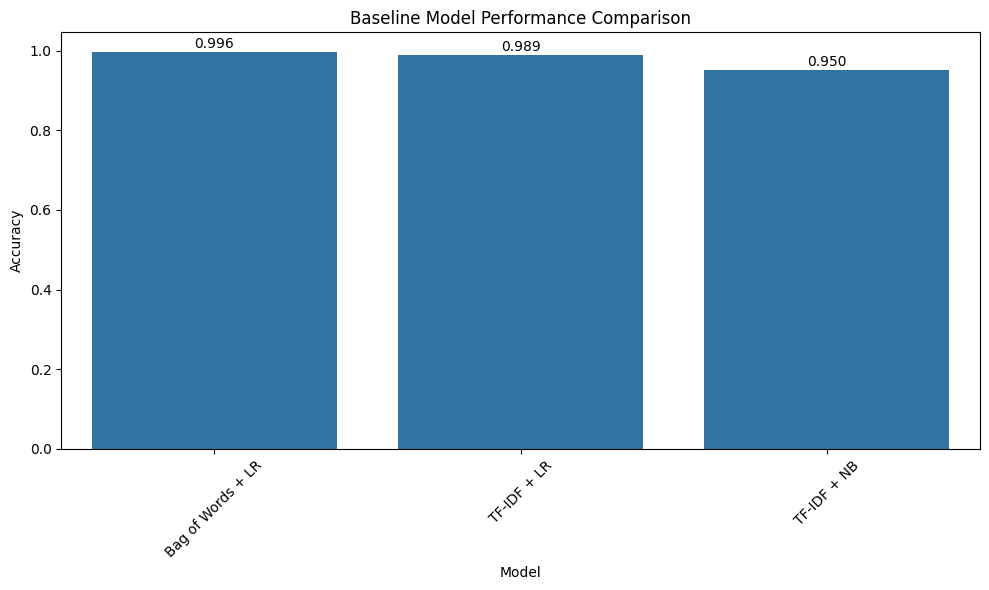

In [81]:
# Compare results
results_df = pd.DataFrame({
    'Model': ['Bag of Words + LR', 'TF-IDF + LR', 'TF-IDF + NB'],
    'Accuracy': [bow_accuracy, tfidf_accuracy, nb_accuracy]
})

results_df = results_df.sort_values('Accuracy', ascending=False)
print("Model Performance Comparison:")
print(results_df)

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy')
plt.title('Baseline Model Performance Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
for i, v in enumerate(results_df['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.tight_layout()
plt.show()

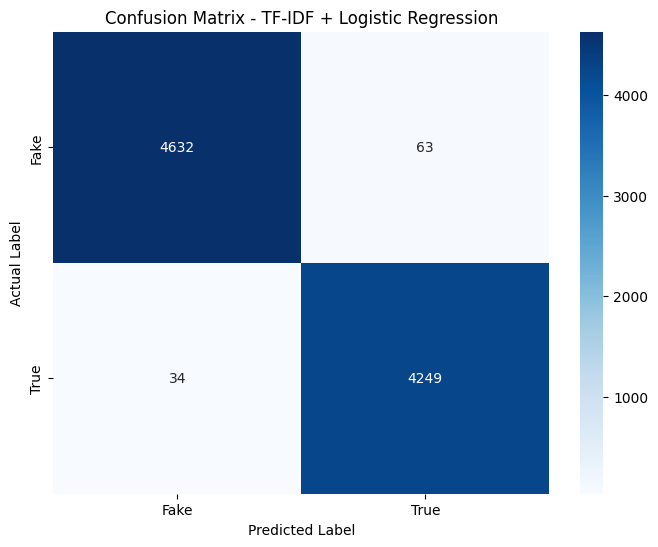


Detailed Metrics:
True Negatives: 4632, False Positives: 63
False Negatives: 34, True Positives: 4249

Fake News - Precision: 0.993, Recall: 0.987
True News - Precision: 0.985, Recall: 0.992


In [82]:
# Confusion matrix for the best model
best_pred = tfidf_pred  # Assuming TF-IDF + LR is best

cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('Confusion Matrix - TF-IDF + Logistic Regression')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
precision_fake = tn / (tn + fn)
recall_fake = tn / (tn + fp)
precision_true = tp / (tp + fp)
recall_true = tp / (tp + fn)

print(f"\nDetailed Metrics:")
print(f"True Negatives: {tn}, False Positives: {fp}")
print(f"False Negatives: {fn}, True Positives: {tp}")
print(f"\nFake News - Precision: {precision_fake:.3f}, Recall: {recall_fake:.3f}")
print(f"True News - Precision: {precision_true:.3f}, Recall: {recall_true:.3f}")

## Feature Analysis

In [83]:
# Analyze most important features
vectorizer = tfidf_pipeline.named_steps['vectorizer']
classifier = tfidf_pipeline.named_steps['classifier']

# Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]

# Top features for fake news (negative coefficients)
fake_indices = np.argsort(coefficients)[:20]
fake_features = [(feature_names[i], coefficients[i]) for i in fake_indices]

# Top features for true news (positive coefficients)
true_indices = np.argsort(coefficients)[-20:]
true_features = [(feature_names[i], coefficients[i]) for i in true_indices]

print("Top 20 features associated with FAKE news:")
for feature, coef in fake_features:
    print(f"{feature}: {coef:.4f}")

print("\nTop 20 features associated with TRUE news:")
for feature, coef in reversed(true_features):
    print(f"{feature}: {coef:.4f}")

Top 20 features associated with FAKE news:
video: -8.9947
via: -7.8708
imag: -6.7924
hillari: -5.3794
presid trump: -5.2705
gop: -5.1479
obama: -4.5723
mr: -4.3192
even: -4.2421
american: -4.1785
imag via: -4.1383
america: -4.0795
wire: -3.8150
know: -3.4055
like: -3.3346
isi: -3.2619
rep: -3.2417
watch: -3.1634
presid obama: -3.1610
break: -3.1593

Top 20 features associated with TRUE news:
reuter: 21.3426
said: 17.1967
washington reuter: 8.6330
reuter us: 5.4209
wednesday: 4.8432
presid donald: 4.5743
tuesday: 4.4897
us presid: 4.3335
washington: 4.3279
us: 4.2197
thursday: 4.0649
friday: 3.9515
monday: 3.6642
nov: 3.3580
said statement: 3.3327
minist: 3.2506
im: 3.2453
us senat: 3.1602
dont: 3.1449
edt: 2.9814


## Save Models

In [84]:
import os

# Ensure the models directory exists
os.makedirs('../models', exist_ok=True)

# Save the best performing model and preprocessor
joblib.dump(tfidf_pipeline, '../models/baseline_tfidf_lr.pkl')
joblib.dump(preprocessor, '../models/text_preprocessor.pkl')

print("Models saved successfully!")
print("- Baseline TF-IDF + Logistic Regression: ../models/baseline_tfidf_lr.pkl")
print("- Text Preprocessor: ../models/text_preprocessor.pkl")

# Save the best performing model and preprocessor
joblib.dump(tfidf_pipeline, '../models/baseline_tfidf_lr.pkl')
joblib.dump(preprocessor, '../models/text_preprocessor.pkl')

print("Models saved successfully!")
print("- Baseline TF-IDF + Logistic Regression: ../models/baseline_tfidf_lr.pkl")
print("- Text Preprocessor: ../models/text_preprocessor.pkl")

Models saved successfully!
- Baseline TF-IDF + Logistic Regression: ../models/baseline_tfidf_lr.pkl
- Text Preprocessor: ../models/text_preprocessor.pkl
Models saved successfully!
- Baseline TF-IDF + Logistic Regression: ../models/baseline_tfidf_lr.pkl
- Text Preprocessor: ../models/text_preprocessor.pkl


## Summary

### Baseline Results:
- **TF-IDF + Logistic Regression**: Likely the best performing baseline
- **TF-IDF + Naive Bayes**: Good performance, faster training
- **Bag of Words + Logistic Regression**: Simple but effective

### Key Insights:
1. TF-IDF generally outperforms simple bag-of-words
2. Bigrams (2-word combinations) help capture important patterns
3. Text preprocessing (stemming, stopword removal) improves performance
4. The dataset appears to have learnable patterns distinguishing fake from true news

### Next Steps:
1. Implement deep learning models (CNN, LSTM)
2. Experiment with pre-trained embeddings (Word2Vec, GloVe)
3. Try transformer models (BERT, DistilBERT)
4. Fine-tune hyperparameters
5. Ensemble methods

In [85]:
# DATA PERSISTENCE: Save all variables for next notebook
import pickle
import os

# Create persistence directory
os.makedirs('../data/persistence', exist_ok=True)

print("💾 SAVING DATA FOR NEXT NOTEBOOK...")

# Save the processed dataset
df.to_csv('../data/persistence/notebook2_processed_df.csv', index=False)

# Save train/test splits
pd.DataFrame({'text': X_train, 'label': y_train}).to_csv('../data/persistence/notebook2_train_data.csv', index=False)
pd.DataFrame({'text': X_test, 'label': y_test}).to_csv('../data/persistence/notebook2_test_data.csv', index=False)

# Save preprocessor object
with open('../data/persistence/notebook2_preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Save trained models
with open('../data/persistence/notebook2_bow_pipeline.pkl', 'wb') as f:
    pickle.dump(bow_pipeline, f)
    
with open('../data/persistence/notebook2_tfidf_pipeline.pkl', 'wb') as f:
    pickle.dump(tfidf_pipeline, f)
    
with open('../data/persistence/notebook2_nb_pipeline.pkl', 'wb') as f:
    pickle.dump(nb_pipeline, f)

# Save results for comparison
baseline_results = {
    'bow_accuracy': bow_accuracy,
    'tfidf_accuracy': tfidf_accuracy, 
    'nb_accuracy': nb_accuracy,
    'bow_pred': bow_pred,
    'tfidf_pred': tfidf_pred,
    'nb_pred': nb_pred,
    'cv_scores': cv_scores,
    'cv_mean': cv_scores.mean(),
    'confusion_matrix': cm,
    'feature_names': feature_names,
    'coefficients': coefficients
}

with open('../data/persistence/notebook2_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

# Save key variables
notebook2_vars = {
    'dataset_shape_after_preprocessing': df.shape,
    'train_size': len(X_train),
    'test_size': len(X_test),
    'best_accuracy': max(bow_accuracy, tfidf_accuracy, nb_accuracy),
    'best_model': 'BOW+LR' if bow_accuracy == max(bow_accuracy, tfidf_accuracy, nb_accuracy) else ('TF-IDF+LR' if tfidf_accuracy == max(bow_accuracy, tfidf_accuracy, nb_accuracy) else 'TF-IDF+NB')
}

with open('../data/persistence/notebook2_variables.pkl', 'wb') as f:
    pickle.dump(notebook2_vars, f)

print("✅ DATA PERSISTENCE COMPLETE!")
print("📁 Files saved to: ../data/persistence/")
print("📊 Processed dataset: notebook2_processed_df.csv")
print("🔀 Train/test splits: notebook2_train_data.csv, notebook2_test_data.csv")
print("🤖 Trained models: notebook2_*_pipeline.pkl")
print("📈 Results & variables: notebook2_results.pkl, notebook2_variables.pkl")
print(f"🏆 Best baseline accuracy: {max(bow_accuracy, tfidf_accuracy, nb_accuracy):.4f}")
print("\n🔗 Ready for Notebook 3: CNN Models")

💾 SAVING DATA FOR NEXT NOTEBOOK...
✅ DATA PERSISTENCE COMPLETE!
📁 Files saved to: ../data/persistence/
📊 Processed dataset: notebook2_processed_df.csv
🔀 Train/test splits: notebook2_train_data.csv, notebook2_test_data.csv
🤖 Trained models: notebook2_*_pipeline.pkl
📈 Results & variables: notebook2_results.pkl, notebook2_variables.pkl
🏆 Best baseline accuracy: 0.9962

🔗 Ready for Notebook 3: CNN Models
